In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
import pandas as pd
from glob import glob
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
# ✅ Load and Merge Datasets
file_paths = glob('/content/drive/My Drive/Cluster_3/*.csv')
station_names = ["Hambanthota_hourly", "Jaffna_hourly", "Kanthale_hourly", "Kilinochchi_hourly", "Mannar_hourly", "Mullativu_hourly", "PointPedro_hourly", "Polonnaruwa_hourly"]

train_dfs = []
test_dfs = []

for i, file in enumerate(file_paths):
    # ✅ Load each dataset
    df = pd.read_csv(file)
    df['timestamp_index'] = pd.to_datetime(df['timestamp_index'])  # Ensure timestamps are datetime

    # ✅ Select Features
    features = ["PM2.5 (ug/m3)", "Temperature (Celsius)", "Relative Humidity (%)", "hour", "month"]
    df = df[['timestamp_index'] + features]

    # ✅ Sort by Timestamp (ensures correct splitting)
    df = df.sort_values(by="timestamp_index")

    # ✅ Normalize Features (if needed)
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df[features]), columns=features)
    df_scaled["timestamp_index"] = df["timestamp_index"].values  # Keep timestamp column

    # ✅ Train-Test Split (80% Train, 20% Test)
    train_size = int(len(df_scaled) * 0.8)
    train_df = df_scaled.iloc[:train_size]
    test_df = df_scaled.iloc[train_size:]

    # ✅ Store for later merging
    train_dfs.append(train_df)
    test_dfs.append(test_df)


In [ ]:
# ✅ Combine All Train Sets & Test Sets
train_df_combined = pd.concat(train_dfs, ignore_index=True)
test_df_combined = pd.concat(test_dfs, ignore_index=True)

print("Combined Train Set Shape:", train_df_combined.shape)
print("Combined Test Set Shape:", test_df_combined.shape)

# ✅ Convert to numpy arrays
train_data = train_df_combined[features].values
test_data = test_df_combined[features].values

Combined Train Set Shape: (12824, 6)
Combined Test Set Shape: (3209, 6)


In [ ]:
# ✅ Create Time Series Sequences
def create_sequences(data, time_steps=24):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps, 0])  # Predict PM2.5
    return np.array(X), np.array(y)

# ✅ Prepare sequences for LSTM
seq_length = 24  # Using past 24 hours to predict next hour
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)

X_train shape: (12800, 24, 5) y_train shape: (12800,)
X_test shape: (3185, 24, 5) y_test shape: (3185,)


In [ ]:
# ✅ Define Deep LSTM Model
model = Sequential([
    LSTM(128, return_sequences=True, activation='relu', input_shape=(24, len(features))),
    Dropout(0.2),
    LSTM(64, return_sequences=True, activation='relu'),
    Dropout(0.2),
    LSTM(32, return_sequences=False, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

# ✅ Compile Model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# ✅ Train Model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.0143 - mae: 0.0822 - val_loss: 0.0102 - val_mae: 0.0692
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - loss: 0.0099 - mae: 0.0669 - val_loss: 0.0078 - val_mae: 0.0607
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - loss: 0.0086 - mae: 0.0617 - val_loss: 0.0070 - val_mae: 0.0569
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - loss: 0.0075 - mae: 0.0576 - val_loss: 0.0062 - val_mae: 0.0506
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - loss: 0.0070 - mae: 0.0548 - val_loss: 0.0053 - val_mae: 0.0489
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.0066 - mae: 0.0523 - val_loss: 0.0056 - val_mae: 0.0459
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - loss: 0.0060 - mae: 0.0498 - val_loss: 0.0052 - val_mae: 0.0453
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - loss: 0.0056 - mae: 0.0477 - val_loss: 0.0051 - val_mae: 0.0426
Epoch 9/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/st

In [ ]:
# ✅ Predict on Train & Test Data
y_train_pred = model.predict(X_train).flatten()
y_test_pred = model.predict(X_test).flatten()

400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [ ]:
# ✅ Display Model Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 24, 128)             │          68,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 24, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 392,933 (1.50 MB)

 Trainable params: 130,977 (511.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 261,956 (1023.27 KB)

In [ ]:
# ✅ Use a separate scaler for PM2.5
pm25_scaler = MinMaxScaler()
df["PM2.5 (ug/m3)"] = pm25_scaler.fit_transform(df[["PM2.5 (ug/m3)"]])

# ✅ Inverse Transform Only PM2.5 Values
y_train_pred = pm25_scaler.inverse_transform(y_train_pred.reshape(-1, 1)).flatten()
y_test_pred = pm25_scaler.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()
y_train = pm25_scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test = pm25_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()


# ✅ Compute Error Metrics for Training Data
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# ✅ Compute Error Metrics for Testing Data
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# ✅ Print Results
print("\n📌 Error Metrics for Training Data:")
print(f"  - MSE:  {mse_train:.4f}")
print(f"  - RMSE: {rmse_train:.4f}")
print(f"  - MAE:  {mae_train:.4f}")
print(f"  - R²:   {r2_train:.4f}")

print("\n📌 Error Metrics for Testing Data:")
print(f"  - MSE:  {mse_test:.4f}")
print(f"  - RMSE: {rmse_test:.4f}")
print(f"  - MAE:  {mae_test:.4f}")
print(f"  - R²:   {r2_test:.4f}")


📌 Error Metrics for Training Data:
  - MSE:  7.8262
  - RMSE: 2.7975
  - MAE:  1.7551
  - R²:   0.7738

📌 Error Metrics for Testing Data:
  - MSE:  8.0850
  - RMSE: 2.8434
  - MAE:  1.7823
  - R²:   0.7329


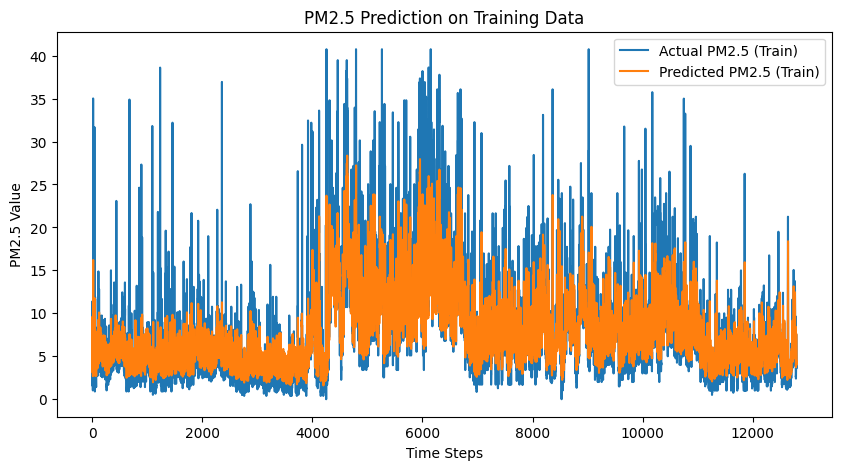

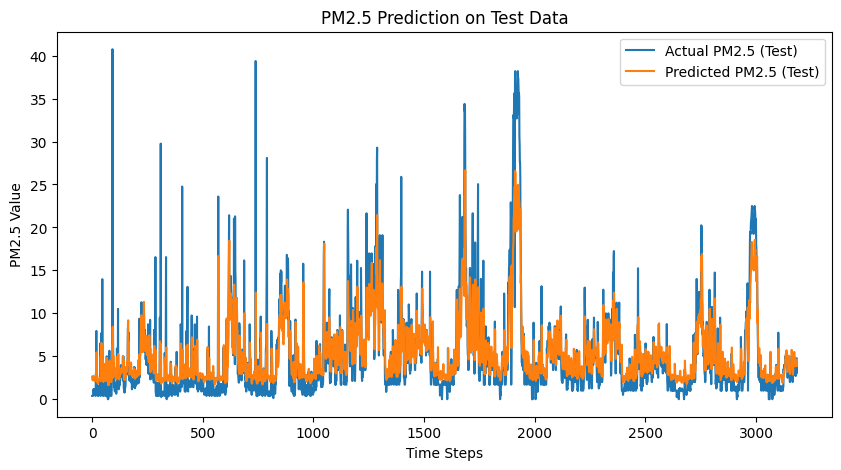

In [ ]:
# ✅ Plot Training Predictions
plt.figure(figsize=(10, 5))
plt.plot(y_train, label="Actual PM2.5 (Train)")
plt.plot(y_train_pred, label="Predicted PM2.5 (Train)")
plt.legend()
plt.title("PM2.5 Prediction on Training Data")
plt.xlabel("Time Steps")
plt.ylabel("PM2.5 Value")
plt.show()

# ✅ Plot Testing Predictions
plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Actual PM2.5 (Test)")
plt.plot(y_test_pred, label="Predicted PM2.5 (Test)")
plt.legend()
plt.title("PM2.5 Prediction on Test Data")
plt.xlabel("Time Steps")
plt.ylabel("PM2.5 Value")
plt.show()